In [0]:
%tensorflow_version 1.x
from keras.layers.convolutional import Conv3D
from skimage import measure, transform
from keras.models import Sequential
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import glob
import math
import cv2

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Converting HR images into LR using FFT.

In [0]:
def fft_lr(img, factor):
    x = int(img.shape[1]//(factor*2))
    imgfft = np.fft.fftn(img)
    imgfft = np.fft.fftshift(imgfft)
    y_center = imgfft.shape[1] // 2
    z_center = imgfft.shape[2] // 2
    imgfft = imgfft[:, y_center-x : y_center+x, z_center-x : z_center+x]
    imgifft = np.fft.ifftn(imgfft)
    lr_img = abs(imgifft)

    lr_img = transform.resize(lr_img, img.shape)
    lr_img /= lr_img.max()
    lr_img *= 255
    return lr_img

In [0]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return round((10 * math.log10(PIXEL_MAX**2 / mse)), 3)

In [0]:
#X_train, Y_train   
batch, x, y, z = 1280, 32, 32, 32
X_train = np.ndarray(shape=(batch, x, y, z), dtype='uint8')
Y_train = np.ndarray(shape=(batch, x, y, z), dtype='uint8')

In [0]:
files = glob.glob("dataset/*.nii.gz")

In [0]:
from random import randint
count = 0
for x in range (1, 9):
    img = nib.load(files[x])
    hr_img = img.get_fdata()
    hr_img /= hr_img.max()
    hr_img *= 255
    hr_img = np.array(hr_img, dtype='uint8')

    lr_img = fft_lr(hr_img, 2.5)

    for i in range(160):
        x = randint(15, 200)
        y = randint(15, 250)
        z = randint(15, 200)

        X_train[count] = lr_img[x:x+32, y:y+32, z:z+32]
        Y_train[count] = hr_img[x:x+32, y:y+32, z:z+32]
        count += 1

In [0]:
print(X_train.shape, X_train[0].shape)

(1280, 32, 32, 32) (32, 32, 32)


In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], Y_train.shape[3], 1))

In [0]:
model = Sequential()
model.add(Conv3D(filters=64, kernel_size=(9,9,9),strides=(1,1,1),padding='same',input_shape=(None, None, None, 1),activation='relu'))
model.add(Conv3D(filters=32, kernel_size=(1,1,1),strides=(1,1,1),padding='same',activation='relu'))
model.add(Conv3D(filters=1, kernel_size=(5,5,5),strides=(1,1,1),padding='same',activation='relu'))
model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, None, None, None,  46720     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, None, None, None,  2080      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, None, None, None,  4001      
Total params: 52,801
Trainable params: 52,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
#training
from keras.optimizers import Adam
adam = Adam(lr = 0.0001)

model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse', 'accuracy'])
hist = model.fit(X_train, Y_train, epochs=1000, batch_size=64)

Epoch 1/1000
1280/1280 [==============================] - 10s 7ms/step - loss: 86.2172 - mean_squared_error: 86.2172 - acc: 0.0763
Epoch 2/1000
1280/1280 [==============================] - 9s 7ms/step - loss: 83.1094 - mean_squared_error: 83.1094 - acc: 0.0774
Epoch 3/1000
1280/1280 [==============================] - 10s 7ms/step - loss: 77.0597 - mean_squared_error: 77.0597 - acc: 0.0768
Epoch 4/1000
1280/1280 [==============================] - 10s 8ms/step - loss: 75.3897 - mean_squared_error: 75.3897 - acc: 0.0777
Epoch 5/1000
1280/1280 [==============================] - 10s 7ms/step - loss: 75.3525 - mean_squared_error: 75.3525 - acc: 0.0779
Epoch 6/1000
1280/1280 [==============================] - 9s 7ms/step - loss: 75.4109 - mean_squared_error: 75.4108 - acc: 0.0781
Epoch 7/1000
1280/1280 [==============================] - 9s 7ms/step - loss: 74.5626 - mean_squared_error: 74.5626 - acc: 0.0776
Epoch 8/1000
1280/1280 [==============================] - 9s 7ms/step - loss: 73.5394 

In [0]:
hist.history.keys()

dict_keys(['loss', 'mean_squared_error', 'acc'])

In [0]:
loss_list = hist.history['loss']
acc_list = hist.history['acc']

import pickle
with open("3dsrcnn_loss.txt", "wb") as fp:   #Pickling
    pickle.dump(loss_list, fp)

with open("3dsrcnn_acc.txt", "wb") as fp:   #Pickling
    pickle.dump(acc_list, fp)

**Loss vs Epochs**

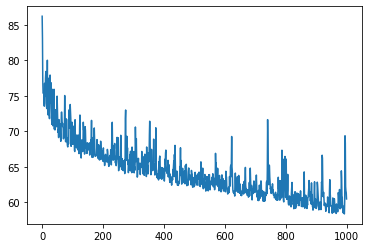

In [0]:
plt.plot(loss_list)

**Accuracy vs Epochs**

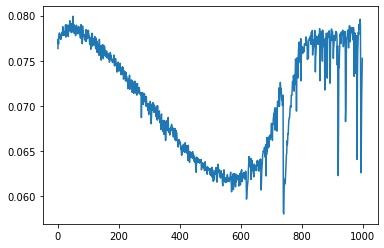

In [0]:
plt.plot(acc_list)

In [0]:
model.save('model.h5')

In [0]:
from keras.models import load_model
model = load_model('model.h5')

In [0]:
img = nib.load('drive/My Drive/Scans/108525_3T_T1w_MPR1.nii.gz')
test_hr = img.get_fdata()
test_hr /= test_hr.max()
test_hr *= 255
test_hr = np.array(test_hr, dtype='uint8')

test_lr = fft_lr(test_hr, 2.5)
test_lr = np.array(test_lr, dtype='uint8')
test_sr = np.ndarray((256, 320, 320), dtype='uint8')

In [0]:
for i in range(0, 256, 64):
    for j in range(0, 320, 64):
        for k in range(0, 320, 64):
            lrx = test_lr[i:i+64, j:j+64, k:k+64]
            lrx = np.reshape(lrx, (1, lrx.shape[0], lrx.shape[1], lrx.shape[2], 1))
            srx = model.predict(lrx)
            srx = np.reshape(srx, (64,64,64))
            test_sr[i:i+64, j:j+64, k:k+64] = srx

In [0]:
lrx = test_lr[113, :, :]
srx = test_sr[113, :, :]
hrx = test_hr[113, :, :]

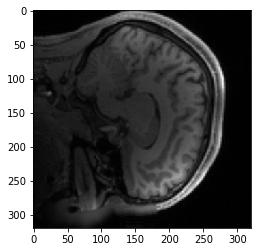

In [0]:
plt.imshow(lrx, cmap='gray')

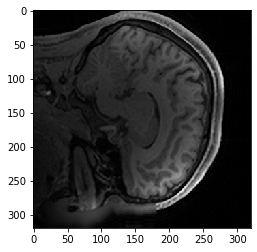

In [0]:
plt.imshow(srx, cmap='gray')

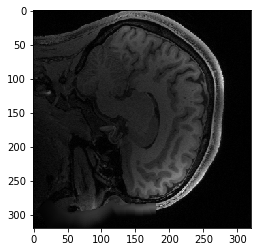

In [0]:
plt.imshow(hrx, cmap='gray')

PSNR and SSIM of a test image.

In [0]:
print(psnr(hrx, srx))
s, d = measure.compare_ssim(hrx, srx, full=True)
print(s)

34.735
0.9011449559951901


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  
